Please install the necessary dependencies using the following command:

In [ ]:
#!pip install sunpy[all] hapiclient

## Embracing dev-driven paradigms in acquiring solar data.

In solar weather analysis, we can distinguish between two fundamental types of data: **images** (remote sensing data) and **time series data** (in situ data).  

- Time series data. These represents measurements of various physical attributes associated with the sun (e.g. solar wind speed)
- Image data. These images serve as snapshots of the solar disc.

By combining these data types in our analysis, we aim to unravel relationships between observed events captured on images and corresponding measured physical attributes. This combined approach allows us to bridge the gap between visual insights and data trends.  

Bellow, we show dev-driven paradigms, that might be usefull for acquiring time series or images.

### Fetching time series data via HAPI

The Heliophysics Data Application Programmer’s Interface (HAPI) is standard interface for serving space weather time series data. HAPI provides easy access to data from various sources. It is designed very intuitive,  where each server (provider) hosts a variety of datasets. These datasets consist of parameters that users may be seeking. Additionally, each dataset comes with a description of the provided data and a preview of the queried information available in CSV or JSON format.   

Here is a list of all servers compatible with HAPI: [HAPI data](https://hapi-server.org/servers/)   

Users have the option to download the data in the aforementioned formats or utilize an API approach. With the API method, users can directly retrieve this data using Python, as demonstrated below.

In this example, we will download data about solar wind's bulk speed, create dataframe that is valid for time series analysis and plot this fetched data with plotly library.

In [3]:
from hapiclient import hapi
import pandas as pd
from datetime import datetime
import numpy as np
import plotly.express as px

In [ ]:
# fetch solar wind bulk speed data
server     = 'https://iswa.gsfc.nasa.gov/IswaSystemWebApp/hapi'
dataset    = 'WIND_SWE_P2M'
parameters = 'BulkSpeed'
start      = '2003-11-10T00:00:00'
stop       = '2003-11-28T00:00:00'
opts       = {'logging': False} # set True for some more info about transfer

data, meta = hapi(server, dataset, parameters, start, stop, **opts)

In [ ]:
# clean data of records filled with -9999.9
filtered_data = [record for record in data if record[1] != -9999.9]
filtered_data = np.array(filtered_data, dtype=[('Time', 'S22'), ('BulkSpeed', '<f8')])

In [ ]:
wind_df = pd.DataFrame(data=filtered_data)
wind_df.head()

,Time,BulkSpeed
0,b'2003-11-10T09:04:12Z',474.9
1,b'2003-11-10T09:05:51Z',478.0
2,b'2003-11-10T09:07:27Z',482.4
3,b'2003-11-10T09:09:04Z',474.9
4,b'2003-11-10T09:10:41Z',465.1


In [ ]:
# Prepare data for time series analysis...

# Convert "Time" column to pandas datetime
wind_df['Time'] = wind_df['Time'].str.decode('utf-8')
wind_df['Time'] = pd.to_datetime(wind_df['Time'], format="%Y-%m-%dT%H:%M:%SZ")

# Extract specific time from "Time" coliumn
wind_df['Year'] = wind_df['Time'].dt.year
wind_df['Month'] = wind_df['Time'].dt.month
wind_df['Day'] = wind_df['Time'].dt.day
wind_df['Hour'] = wind_df['Time'].dt.hour
wind_df['Minute'] = wind_df['Time'].dt.minute
wind_df['Second'] = wind_df['Time'].dt.second

# rearange so "BulkSpeed" is last column
speed_column = wind_df.pop('BulkSpeed')
wind_df['BulkSpeed'] = speed_column

# Set "Time" column as the index
wind_df.set_index('Time', inplace=True)

In [ ]:
wind_df.head()

,Year,Month,Day,Hour,Minute,Second,BulkSpeed
Time,,,,,,,
2003-11-10 09:04:12,2003,11,10,9,4,12,474.9
2003-11-10 09:05:51,2003,11,10,9,5,51,478.0
2003-11-10 09:07:27,2003,11,10,9,7,27,482.4
2003-11-10 09:09:04,2003,11,10,9,9,4,474.9
2003-11-10 09:10:41,2003,11,10,9,10,41,465.1


In [ ]:
# Plot fetched data with plotly
fig = px.scatter(wind_df, x=wind_df.index, y="BulkSpeed", title='Bulk Speed of wind in time')
fig.show()

### Acquiring and manipulating images via SunPy

Sunpy is community-developed solar data analysis enviroment for Python. Sunpy provides tools for downloading, processing and manipulating solar images from various sources. These sources provide images of the Sun, that can be filltered by different time, wavelength or insturment. Sunpy often works with data stored in the .fits file format. So when you use Sunpy to download solar data, they are in .fits file format.

In this example, we will download few SOHO EIT and STEREO A & B EUVI images via **Fido** interface. We will try to increase quality of downloaded SOHO EIT files and crop-and-zoom on STEREO B EUVI image.

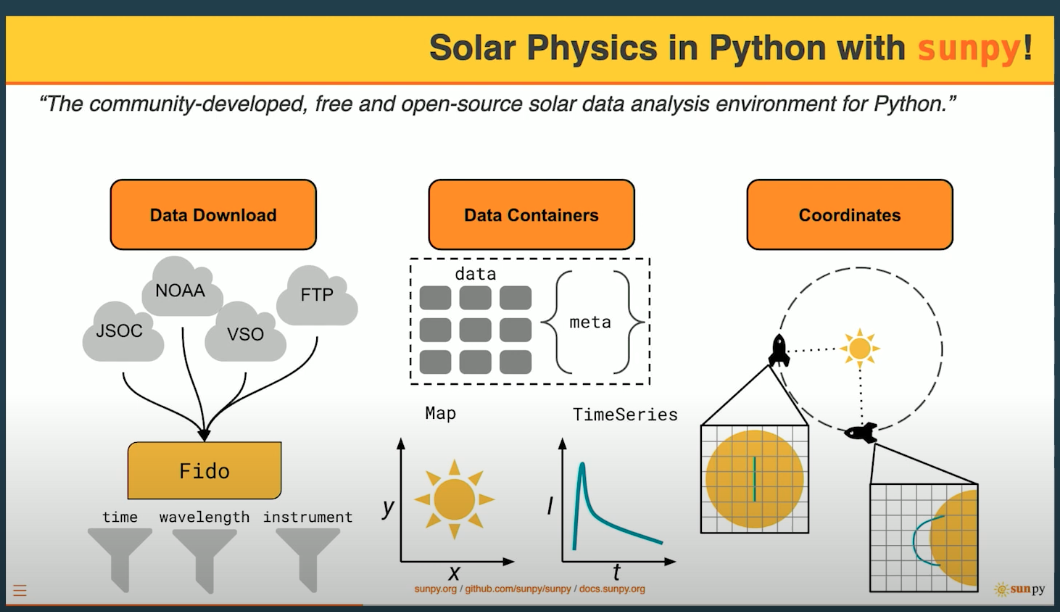

In [8]:
from sunpy.net import Fido, attrs as a
import astropy.units as u
import matplotlib.pyplot as plt
import sunpy.map
from astropy.visualization import ZScaleInterval
from astropy.io import fits
from matplotlib import pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord

In [ ]:
# fido search for specified image data. With print(a.Instrument), we can see all instruments that Fido provides
query = Fido.search(
    a.Time('2003-11-20 10:00', '2003-11-20 20:00'),
    a.Wavelength(195*u.angstrom),
    a.Instrument.eit
)

print(query)

Results from 1 Provider:

45 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 27.245 Mbyte

       Start Time               End Time        Source ... Extent Type   Size 
                                                       ...              Mibyte
----------------------- ----------------------- ------ ... ----------- -------
2003-11-20 10:24:42.000 2003-11-20 10:24:47.000   SOHO ...    FULLDISK 0.51074
2003-11-20 10:36:10.000 2003-11-20 10:36:15.000   SOHO ...    FULLDISK 0.51074
2003-11-20 10:48:10.000 2003-11-20 10:48:15.000   SOHO ...    FULLDISK 0.51074
2003-11-20 11:00:10.000 2003-11-20 11:00:15.000   SOHO ...    FULLDISK 0.51074
2003-11-20 11:12:10.000 2003-11-20 11:12:15.000   SOHO ...    FULLDISK 0.51074
2003-11-20 11:24:10.000 2003-11-20 11:24:15.000   SOHO ...    FULLDISK 0.51074
2003-11-20 11:36:10.000 2003-11-20 11:36:15.000   SOHO ...    FULLDISK 0.51074
2003-11-20 11:48:10.000 2003-11-20 11:48:15.000   SOHO ...    FULLDISK

In [ ]:
# and download data to folder
files = Fido.fetch(query, path='data/eit')
print(files)

Files Downloaded:   0%|          | 0/45 [00:00<?, ?file/s]

efz20031120.104810:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.110010:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.103610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.102442:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.111210:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.112410:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.113610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.114810:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.120010:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.121210:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.122410:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.123610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.124842:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.131333:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

efz20031120.132534:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.134810:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.140011:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.141211:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.142410:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.143610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.144812:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.150011:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.151243:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.152410:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.154811:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.160010:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.153610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.161210:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.162442:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.163610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.164810:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.170010:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.171211:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.172411:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.173612:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.174810:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.180010:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.181210:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.182412:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.183610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.184842:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.191334:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

efz20031120.192535:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.193610:   0%|          | 0.00/536k [00:00<?, ?B/s]

efz20031120.194810:   0%|          | 0.00/536k [00:00<?, ?B/s]

['data/eit/efz20031120.102442', 'data/eit/efz20031120.103610', 'data/eit/efz20031120.104810', 'data/eit/efz20031120.110010', 'data/eit/efz20031120.111210', 'data/eit/efz20031120.112410', 'data/eit/efz20031120.113610', 'data/eit/efz20031120.114810', 'data/eit/efz20031120.120010', 'data/eit/efz20031120.121210', 'data/eit/efz20031120.122410', 'data/eit/efz20031120.123610', 'data/eit/efz20031120.124842', 'data/eit/efz20031120.131333', 'data/eit/efz20031120.132534', 'data/eit/efz20031120.134810', 'data/eit/efz20031120.140011', 'data/eit/efz20031120.141211', 'data/eit/efz20031120.142410', 'data/eit/efz20031120.143610', 'data/eit/efz20031120.144812', 'data/eit/efz20031120.150011', 'data/eit/efz20031120.151243', 'data/eit/efz20031120.152410', 'data/eit/efz20031120.153610', 'data/eit/efz20031120.154811', 'data/eit/efz20031120.160010', 'data/eit/efz20031120.161210', 'data/eit/efz20031120.162442', 'data/eit/efz20031120.163610', 'data/eit/efz20031120.164810', 'data/eit/efz20031120.170010', 'data/e

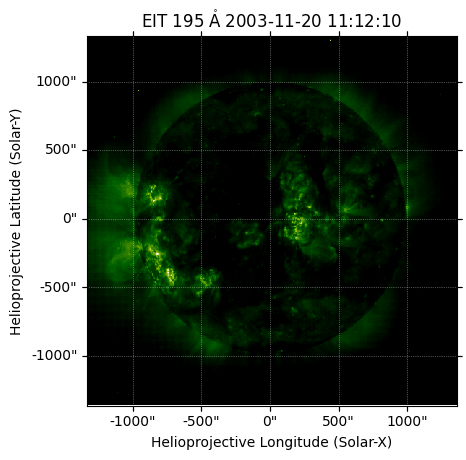

In [ ]:
solar_map = sunpy.map.Map(files[4])
solar_map.plot()
plt.show()

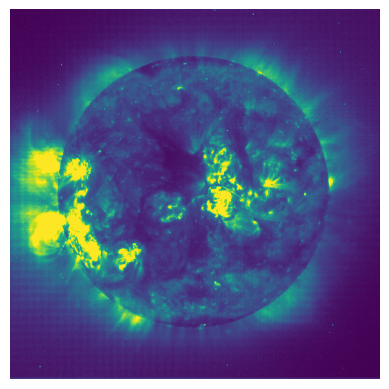

In [ ]:
image = fits.getdata(files[4])
image = np.flipud(image) # flip image correctly
zscale = ZScaleInterval()
plt.imshow(zscale(image)) # or add cmap="gray"
plt.axis('off')
plt.show()

#### Second example for SunPy

Now we will fetch STEREO A & B images via Fido and then create cropped submap of the original image.

In [ ]:
query = Fido.search(
    a.Time('2013-05-29 18:00', '2013-05-29 18:10:10'),
    a.Wavelength(195*u.angstrom),
    a.Instrument.secchi,
    a.Detector.euvi
)

print(query)

Results from 1 Provider:

4 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 33.638 Mbyte

       Start Time               End Time         Source  ... Extent Type   Size 
                                                         ...              Mibyte
----------------------- ----------------------- -------- ... ----------- -------
2013-05-29 18:00:30.000 2013-05-29 18:00:38.000 STEREO_A ...    FULLDISK 8.02002
2013-05-29 18:00:58.000 2013-05-29 18:01:06.000 STEREO_B ...    FULLDISK 8.02002
2013-05-29 18:05:30.000 2013-05-29 18:05:38.000 STEREO_A ...    FULLDISK 8.02002
2013-05-29 18:05:58.000 2013-05-29 18:06:06.000 STEREO_B ...    FULLDISK 8.02002




In [ ]:
files = Fido.fetch(query, path='data/secchi')
print(files)

Files Downloaded:   0%|          | 0/4 [00:00<?, ?file/s]

20130529_180530_n4eub.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

20130529_180030_n4eua.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

20130529_180030_n4eub.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

20130529_180530_n4eua.fts:   0%|          | 0.00/8.41M [00:00<?, ?B/s]

['data/secchi/20130529_180030_n4eua.fts', 'data/secchi/20130529_180030_n4eub.fts', 'data/secchi/20130529_180530_n4eua.fts', 'data/secchi/20130529_180530_n4eub.fts']


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


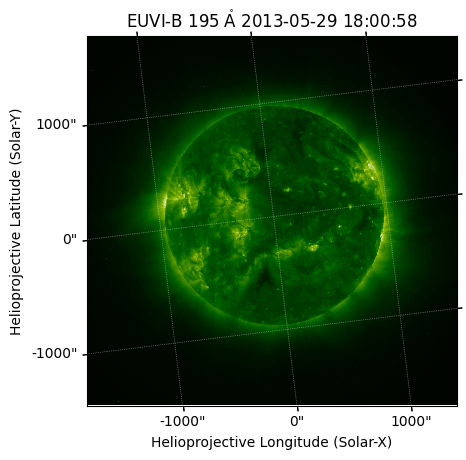

In [ ]:
# original image
stereo_a_file = sunpy.map.Map(files[1])
stereo_a_file.plot()
plt.show()

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


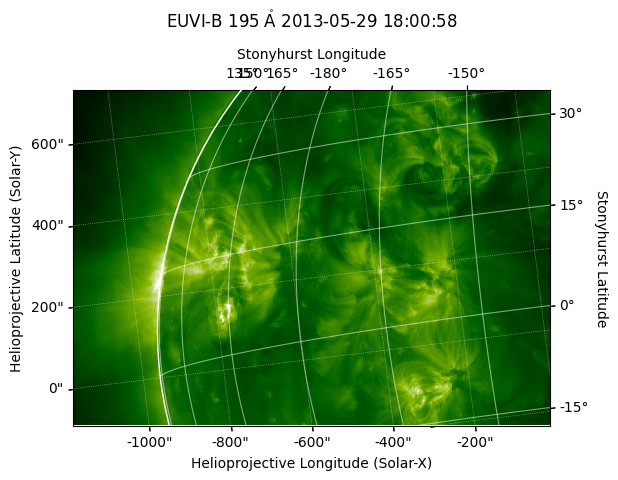

In [ ]:

top_right = SkyCoord(-1100 * u.arcsec, -100 * u.arcsec, frame=stereo_a_file.coordinate_frame)
bottom_left = SkyCoord(0 * u.arcsec, 600 * u.arcsec, frame=stereo_a_file.coordinate_frame)
swap_submap = stereo_a_file.submap(bottom_left, top_right=top_right)

fig = plt.figure()
ax = fig.add_subplot(projection=swap_submap)
image = swap_submap.plot(axes=ax)
swap_submap.draw_limb(axes=ax)
swap_submap.draw_grid(axes=ax)

# Make some room and put the title at the top of the figure
ax.set_position([0.1, 0.1, 0.8, 0.7])
ax.set_title(ax.get_title(), pad=45)

plt.show()

### Obtaining GOES flare class data from Sunpy

Solar flares are classified into B, C, M, and X classes based on their strength, as measured by GOES X-ray Sensor. B-class flares are the weakest, while X-class flares are the strongest. Also each letter class has a numerical scale from 1-9 (e.g., C1 is weaker than C4), but extremely powerful X-class flares may exceed the X9 rating.   

We can obtain this data via Sunpy's Fido. In this example, we will look for flares stronger than M5 ten days before and ten days after extreme event occuring around 2003/10/30.


In [9]:
event_type = "FL"
tstart = "2003/10/20"
tend = "2003/11/09"
result = Fido.search(a.Time(tstart, tend),
                     a.hek.EventType(event_type),
                     a.hek.FL.GOESCls > "M5.0",
                     a.hek.OBS.Observatory == "GOES")

In [10]:
# data has many columns
print(result.all_colnames)

['SOL_standard', 'active', 'ar_compactnesscls', 'ar_mcintoshcls', 'ar_mtwilsoncls', 'ar_noaaclass', 'ar_noaanum', 'ar_numspots', 'ar_penumbracls', 'ar_polarity', 'ar_zurichcls', 'area_atdiskcenter', 'area_atdiskcenteruncert', 'area_raw', 'area_uncert', 'area_unit', 'bound_ccnsteps', 'bound_ccstartc1', 'bound_ccstartc2', 'bound_chaincode', 'boundbox_c1ll', 'boundbox_c1ur', 'boundbox_c2ll', 'boundbox_c2ur', 'chaincodetype', 'comment_count', 'concept', 'event_avg_rating', 'event_c1error', 'event_c2error', 'event_clippedspatial', 'event_clippedtemporal', 'event_coord1', 'event_coord2', 'event_coord3', 'event_coordsys', 'event_coordunit', 'event_description', 'event_endtime', 'event_expires', 'event_importance', 'event_importance_num_ratings', 'event_mapurl', 'event_maskurl', 'event_npixels', 'event_peaktime', 'event_pixelunit', 'event_probability', 'event_score', 'event_starttime', 'event_testflag', 'event_title', 'event_type', 'eventtype', 'fl_efoldtime', 'fl_efoldtimeunit', 'fl_fluence',

In [11]:
# this is what we are looking for
print(result.show("event_peaktime", "fl_goescls"))

Results from 1 Provider:

15 Results from the HEKClient:

     event_peaktime     fl_goescls
----------------------- ----------
2003-10-22 20:07:00.000       M9.9
2003-10-23 08:35:00.000       X5.4
2003-10-23 20:04:00.000       X1.1
2003-10-24 02:54:00.000       M7.6
2003-10-26 06:54:00.000       X1.2
2003-10-26 18:19:00.000       X1.2
2003-10-26 21:40:00.000       M7.6
2003-10-27 12:43:00.000       M6.7
2003-10-28 11:10:00.000       X17.
2003-10-29 20:49:00.000       X10.
2003-11-02 17:25:00.000       X8.3
2003-11-03 01:30:00.000       X2.7
2003-11-03 09:55:00.000       X3.9
2003-11-04 19:50:00.000       X28.
2003-11-05 10:52:00.000       M5.3




In [12]:
# this will transform results to hek table, for better manipulation
hek_results = result["hek"]

In [14]:
# filter only this useful columns
filtered_results = hek_results["event_starttime", "event_peaktime",
                               "event_endtime", "fl_goescls", "ar_noaanum"]

In [16]:
# data are ready for further manipulation as needed
for record in filtered_results:
    print(f"Flare class {record['fl_goescls']} peaked on {record['event_peaktime']}")

Flare class M9.9 peaked on 2003-10-22 20:07:00.000
Flare class X5.4 peaked on 2003-10-23 08:35:00.000
Flare class X1.1 peaked on 2003-10-23 20:04:00.000
Flare class M7.6 peaked on 2003-10-24 02:54:00.000
Flare class X1.2 peaked on 2003-10-26 06:54:00.000
Flare class X1.2 peaked on 2003-10-26 18:19:00.000
Flare class M7.6 peaked on 2003-10-26 21:40:00.000
Flare class M6.7 peaked on 2003-10-27 12:43:00.000
Flare class X17. peaked on 2003-10-28 11:10:00.000
Flare class X10. peaked on 2003-10-29 20:49:00.000
Flare class X8.3 peaked on 2003-11-02 17:25:00.000
Flare class X2.7 peaked on 2003-11-03 01:30:00.000
Flare class X3.9 peaked on 2003-11-03 09:55:00.000
Flare class X28. peaked on 2003-11-04 19:50:00.000
Flare class M5.3 peaked on 2003-11-05 10:52:00.000


### Obtaining solar disk images via Helioviewer API

[The Helioviewer Project](https://helioviewer.org) maintains a set of Public APIs with the goal of improving access to solar and heliospheric datasets to scientists, educators, developers, and the general public - statement in Helioviewer API documentation. This api provides way to collect images from various missions and instruments [Data sources](https://api.helioviewer.org/docs/v2/appendix/data_sources.html). By default, fetched images are black-white. There is API call that provides colorful image, but needs specific id of an image as a parameter.

In this example, we showcase how to obtain black-white solar disk image in .jp2 format, then colorful image.

In [ ]:
from PIL import Image
import requests

In [ ]:
url = "https://api.helioviewer.org/v2/getJP2Image/"
params = {
    "date": "2003-11-20T11:23:10Z",
    "sourceId": "1"
}


response = requests.get(url, params=params)

if response.status_code == 200:

    with open('soho_eit_helioviewer.jp2', 'wb') as f:
        f.write(response.content)
    print("Image downloaded successfully.")

    # can not open image in collab
    #img = Image.open('soho_eit_20031120_112310.jp2')
    #img.show()
else:
    print(f"Failed to download the image. Status code: {response.status_code}")

Image downloaded successfully.


#### Colorful images
- to download colorful images, we need lengthy api call with more parameters, to fetch image id
- after we get image id, we can run /downloadScreenshot/ api call with id as parameter
- quality might lower

In [ ]:
# id of image got via example request: https://api.helioviewer.org/v2/takeScreenshot/?date=2014-01-01T23:59:59Z&imageScale=2.4204409&layers=[SDO,AIA,AIA,335,1,100]&events=[AR,HMI_HARP;SPoCA,1],[CH,all,1]&eventsLabels=false&x0=0&y0=0&width=1920&height=1200
# or: https://api.helioviewer.org/v2/takeScreenshot/?date=2014-01-01T23:59:59Z&imageScale=2.4204409&layers=[SDO,AIA,AIA,171,1,100]&x0=0&y0=0&width=1920&height=1200


url = "https://api.helioviewer.org/v2/takeScreenshot/"
params = {
    "date": "2003-11-20T11:28:10Z",
    "imageScale": 2.4204409,
    "layers": "[SOHO,EIT,EIT,195,1,100]",
    "x0": 0,
    "y0": 0,
    "width": 1920,
    "height": 1200
}

image_id = 0

# Make the HTTP GET request
response = requests.get(url, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Parse the JSON response
    json_data = response.json()

    # Check if the key "id" exists in the JSON data
    if "id" in json_data:
        # Store the value with key "id" as a Python variable named "image_id"
        image_id = json_data["id"]

    # Now, you can work with the "image_id" variable
    print("Image ID:", image_id)
else:
    print(f"Error: {response.status_code}, {response.text}")

Image ID: 35501630


In [ ]:
# use image_id as a parameter for /downloadScreenshot/ API call

url = "https://api.helioviewer.org/v2/downloadScreenshot/"
params = {
    "id": image_id
}


response = requests.get(url, params=params)

if response.status_code == 200:

    with open('soho_eit_helioviewer_color.png', 'wb') as f:
        f.write(response.content)
    print("Image downloaded successfully.")

    # cannot open in google collab
    #img = Image.open('helioviewer_color.png')
    #img.show()
else:
    print(f"Failed to download the image. Status code: {response.status_code}")

Image downloaded successfully.


### Fetching SDO images via Image Parameter API
[Image Parameter API](http://dmlab.cs.gsu.edu/dmlabapi/isd_docs.html) offers a curated dataset of image parameters from the Solar Dynamics Observatory mission. While their provided code isn't packaged as a Python "pip" library – requiring users to manually incorporate it into their projects – it proves beneficial for retrieving images through the Image Parameter API. Additionally, they offer a standard web API that can be invoked using the "requests" Python library, allowing users to save the API response as an image.   
  
In this example, we will fetch and save solar image from SDO mission in .jpg format.
  
As of the current date (11/13/2023), the API is currently experiencing downtime. We will try to contact creators to obtain more information about its availability.

Edit (11/18/2023): contacted creators, API is fixed.

In [ ]:
import requests

In [ ]:
# 2k2k-pixel, 512x512-pixel and 256x256pixel images are available
# http://dmlab.cs.gsu.edu/dmlabapi/images/SDO/AIA/2k/?wave=171&starttime=2012-02-13T22:10:00
# http://dmlab.cs.gsu.edu/dmlabapi/images/SDO/AIA/256/?wave=171&starttime=2012-02-13T22:10:00


url = "http://dmlab.cs.gsu.edu/dmlabapi/images/SDO/AIA/2k/"
params = {
    "wave": "171",
    "starttime": "2012-02-13T22:10:00"
}
filename = "image_parameter_api.jpg"

response = requests.get(url, params=params)


if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"Image downloaded and saved as {filename}")
else:
    print("Failed to download the image.")

Image downloaded and saved as image_parameter_api.jpg
